In [1]:
from IPython.display import clear_output
import pandas as pd
import os
import shutil

In [2]:
!pip install wandb timm torchvision einops fastai
clear_output()

In [3]:
import torchvision.transforms as transforms
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import timm
import wandb

In [4]:
#importing libraries
from fastai import *
from fastai.vision.all import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
from pathlib import Path

In [5]:
x  = "/kaggle/input/kermany2018/OCT2017 "
path = Path(x)
path.ls()

(#3) [Path('/kaggle/input/kermany2018/OCT2017 /val'),Path('/kaggle/input/kermany2018/OCT2017 /test'),Path('/kaggle/input/kermany2018/OCT2017 /train')]

In [6]:
data = ImageDataLoaders.from_folder(
    path,
    item_tfms= Resize(224),
    batch_size=32,  # Adjust batch size as needed
    num_workers=4,  # Adjust number of workers as needed
    seed=42,  # Set a random seed for reproducibility (optional)
    size=image_size,
    train='train',
    valid='test'
)

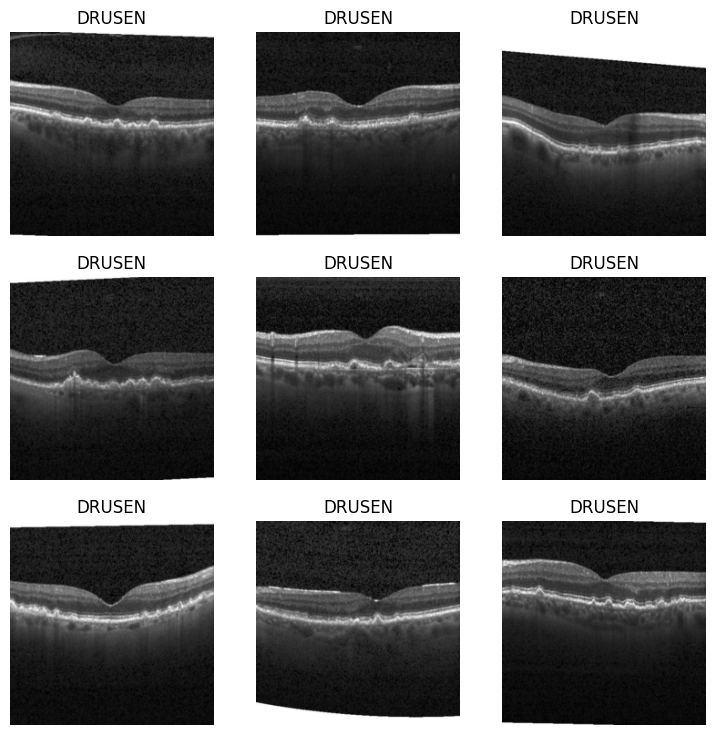

In [7]:
data.valid.show_batch()

In [8]:
# Copyright (c) ByteDance, Inc. and its affiliates.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

"""
Mostly copy-paste from Swin-Transformer libarary:
https://github.com/facebookresearch/dino
https://github.com/microsoft/Swin-Transformer/blob/main/models/swin_transformer.py
"""

import os
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist

from math import sqrt
from functools import partial
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super(Mlp, self).__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r"""Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super(WindowAttention, self).__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2 Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn_out = attn
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn_out

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops

    @staticmethod
    def compute_macs(module, input, output):
        B, N, C = input[0].shape

        module.__flops__ += module.flops(N) * B


class SwinTransformerBlock(nn.Module):
    r"""Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        self.H = input_resolution[0]
        self.W = input_resolution[1]

        self.attn_mask_dict = {} # {self.H: self.create_attn_mask(self.H, self.W)}


    def create_attn_mask(self, H, W):
        # calculate attention mask for SW-MSA

        Hp = int(np.ceil(H / self.window_size)) * self.window_size
        Wp = int(np.ceil(W / self.window_size)) * self.window_size
        img_mask = torch.zeros((1, Hp, Wp, 1))  # 1 Hp Wp 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask


    def forward(self, x):

        B, L, C = x.shape
        H = int(sqrt(L))
        W = H

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # pad feature maps to multiples of window size
        pad_l = pad_t = 0
        pad_r = (self.window_size - W % self.window_size) % self.window_size
        pad_b = (self.window_size - H % self.window_size) % self.window_size
        x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
        _, Hp, Wp, _ = x.shape

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))

            if H is self.attn_mask_dict.keys():
                attn_mask = self.attn_mask_dict[H]
            else:
                self.attn_mask_dict[H] = self.create_attn_mask(H, W).to(x.device)
                attn_mask = self.attn_mask_dict[H]

        else:
            shifted_x = x
            attn_mask = None

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows, attn = self.attn(x_windows, attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, Hp, Wp)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        if pad_r > 0 or pad_b > 0:
            x = x[:, :H, :W, :].contiguous()

        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x, attn

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size} mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r"""Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """ Forward function.
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
        """
        B, L, C = x.shape
        H = int(sqrt(L))
        W = H

        x = x.view(B, H, W, C)

        # padding
        pad_input = (H % 2 == 1) or (W % 2 == 1)
        if pad_input:
            x = F.pad(x, (0, 0, 0, W % 2, 0, H % 2))

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x


    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth

        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            x, _ = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def forward_with_features(self, x):
        fea = []
        for blk in self.blocks:
            x, _ = blk(x)
            fea.append(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x, fea

    def forward_with_attention(self, x):
        attns = []
        for blk in self.blocks:
            x, attn = blk(x)
            attns.append(attn)
        if self.downsample is not None:
            x = self.downsample(x)
        return x, attns


    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):

        # # FIXME look at relaxing size constraints
        # assert H == self.img_size[0] and W == self.img_size[1], \
        #     f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        x = self.proj(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x
        #return x.transpose(1, 2).reshape(B, C, H, W)


    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class SwinTransformer(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030
    Args:
        img_size (int | tuple(int)): Input image size.
        patch_size (int | tuple(int)): Patch size.
        in_chans (int): Number of input channels.
        num_classes (int): Number of classes for classification head.
        embed_dim (int): Embedding dimension.
        depths (tuple(int)): Depth of Swin Transformer layers.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: Truee
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set.
        drop_rate (float): Dropout rate.
        attn_drop_rate (float): Attention dropout rate.
        drop_path_rate (float): Stochastic depth rate.
        norm_layer (nn.Module): normalization layer.
        ape (bool): If True, add absolute position embedding to the patch embedding.
        patch_norm (bool): If True, add normalization after patch embedding.
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.,
                 norm_layer=partial(nn.LayerNorm, eps=1e-6), ape=False, patch_norm=True,
                 return_all_tokens=False, use_mean_pooling=True, masked_im_modeling=False):

        super().__init__()

        self.num_classes = num_classes
        self.depths = depths
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio
        self.return_all_tokens = return_all_tokens

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        # todo: to be implemented
        return {'relative_position_bias_table'}

    def forward(self, x):
        # patch linear embedding
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x_region = self.norm(x)  # B L C
        x = self.avgpool(x_region.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)

        return self.head(x)

    def get_selfattention(self, x, n=1):
        # n=1 return the last layer attn map; otherwise return attn maps in all layers
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        if n==1:
            return self.get_last_selfattention(x)
        else:
            return self.get_all_selfattention(x)

    def get_last_selfattention(self, x):

        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1:
                x = layer(x)
            else:
                x, attns = layer.forward_with_attention(x)
                return attns[-1]

    def get_all_selfattention(self, x):
        attn_out = []

        for layer in self.layers:
            x, attns = layer.forward_with_attention(x)
            attn_out += attns

        return attn_out

    def get_intermediate_layers(self, x, n=1, return_patch_avgpool=False):

        num_blks = sum(self.depths)
        start_idx = num_blks - n

        sum_cur = 0
        for i, d in enumerate(self.depths):
            sum_cur_new = sum_cur + d
            if start_idx >= sum_cur and start_idx < sum_cur_new:
                start_stage = i
                start_blk = start_idx - sum_cur
            sum_cur = sum_cur_new


        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        # we will return the averaged token features from the `n` last blocks
        # note: there is no [CLS] token in Swin Transformer
        output = []
        s = 0
        for i, layer in enumerate(self.layers):
            x, fea = layer.forward_with_features(x)

            if i >= start_stage:
                for x_ in fea[start_blk:]:

                    if i == len(self.layers)-1: # use the norm in the last stage
                        x_ = self.norm(x_)

                    x_avg = torch.flatten(self.avgpool(x_.transpose(1, 2)), 1)  # B C
                    if return_patch_avgpool:
                        x_o = x_avg
                    else:
                        x_o = torch.cat((x_avg.unsqueeze(1), x_), dim=1)
                    # print(f'Stage {i},  x_o {x_o.shape}')
                    output.append(x_o)

                start_blk = 0

        #return torch.cat(output, dim=-1)
        return output

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
            if dist.get_rank() == 0:
                print(f"GFLOPs layer_{i}: {layer.flops() / 1e9}")
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops

    def init_weights(self, pretrained='', pretrained_layers=[], verbose=True):
        if os.path.isfile(pretrained):
            pretrained_dict = torch.load(pretrained, map_location='cpu')
            logging.info(f'=> loading pretrained model {pretrained}')
            model_dict = self.state_dict()
            pretrained_dict = {
                k: v for k, v in pretrained_dict.items()
                if k in model_dict.keys()
            }
            need_init_state_dict = {}
            for k, v in pretrained_dict.items():
                need_init = (
                        k.split('.')[0] in pretrained_layers
                        or pretrained_layers[0] is '*'
                        or 'relative_position_index' not in k
                        or 'attn_mask' not in k
                )

                if need_init:
                    if verbose:
                        logging.info(f'=> init {k} from {pretrained}')

                    if 'relative_position_bias_table' in k and v.size() != model_dict[k].size():
                        relative_position_bias_table_pretrained = v
                        relative_position_bias_table_current = model_dict[k]
                        L1, nH1 = relative_position_bias_table_pretrained.size()
                        L2, nH2 = relative_position_bias_table_current.size()
                        if nH1 != nH2:
                            logging.info(f"Error in loading {k}, passing")
                        else:
                            if L1 != L2:
                                logging.info(
                                    '=> load_pretrained: resized variant: {} to {}'
                                        .format((L1, nH1), (L2, nH2))
                                )
                                S1 = int(L1 ** 0.5)
                                S2 = int(L2 ** 0.5)
                                relative_position_bias_table_pretrained_resized = torch.nn.functional.interpolate(
                                    relative_position_bias_table_pretrained.permute(1, 0).view(1, nH1, S1, S1),
                                    size=(S2, S2),
                                    mode='bicubic')
                                v = relative_position_bias_table_pretrained_resized.view(nH2, L2).permute(1, 0)

                    if 'absolute_pos_embed' in k and v.size() != model_dict[k].size():
                        absolute_pos_embed_pretrained = v
                        absolute_pos_embed_current = model_dict[k]
                        _, L1, C1 = absolute_pos_embed_pretrained.size()
                        _, L2, C2 = absolute_pos_embed_current.size()
                        if C1 != C1:
                            logging.info(f"Error in loading {k}, passing")
                        else:
                            if L1 != L2:
                                logging.info(
                                    '=> load_pretrained: resized variant: {} to {}'
                                        .format((1, L1, C1), (1, L2, C2))
                                )
                                S1 = int(L1 ** 0.5)
                                S2 = int(L2 ** 0.5)
                                absolute_pos_embed_pretrained = absolute_pos_embed_pretrained.reshape(-1, S1, S1, C1)
                                absolute_pos_embed_pretrained = absolute_pos_embed_pretrained.permute(0, 3, 1, 2)
                                absolute_pos_embed_pretrained_resized = torch.nn.functional.interpolate(
                                    absolute_pos_embed_pretrained, size=(S2, S2), mode='bicubic')
                                v = absolute_pos_embed_pretrained_resized.permute(0, 2, 3, 1).flatten(1, 2)

                    need_init_state_dict[k] = v
            self.load_state_dict(need_init_state_dict, strict=False)

    def freeze_pretrained_layers(self, frozen_layers=[]):
        for name, module in self.named_modules():
            if (
                    name.split('.')[0] in frozen_layers
                    or '.'.join(name.split('.')[0:2]) in frozen_layers
                    or (len(frozen_layers) > 0 and frozen_layers[0] is '*')
            ):
                for _name, param in module.named_parameters():
                    param.requires_grad = False
                logging.info(
                    '=> set param {} requires grad to False'
                        .format(name)
                )
        for name, param in self.named_parameters():
            if (
                    name.split('.')[0] in frozen_layers
                    or (len(frozen_layers) > 0 and frozen_layers[0] is '*')
                    and param.requires_grad is True
            ):
                param.requires_grad = False
                logging.info(
                    '=> set param {} requires grad to False'
                        .format(name)
                )
        return self

    def get_num_layers(self):

        return sum(self.depths)

<>:728: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:787: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:798: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:728: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:787: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:798: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_121/2857841498.py:728: SyntaxWarning: "is" with a literal. Did you mean "=="?
  or pretrained_layers[0] is '*'
/tmp/ipykernel_121/2857841498.py:787: SyntaxWarning: "is" with a literal. Did you mean "=="?
  or (len(frozen_layers) > 0 and frozen_layers[0] is '*')
/tmp/ipykernel_121/2857841498.py:798: SyntaxWarning: "is" with a literal. Did you mean "=="?
  or (len(frozen_layers) > 0 and frozen_layers[0] is '*')


In [9]:
class SwinTransformerClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.model = SwinTransformer(num_classes=4)
    def forward(self, x):
        return self.model(x)

In [10]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = SwinTransformerClassifier(num_classes=4).to(device)
learn = Learner(data, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy, model_dir='/kaggle/working/')

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SuggestedLRs(valley=6.30957365501672e-05)

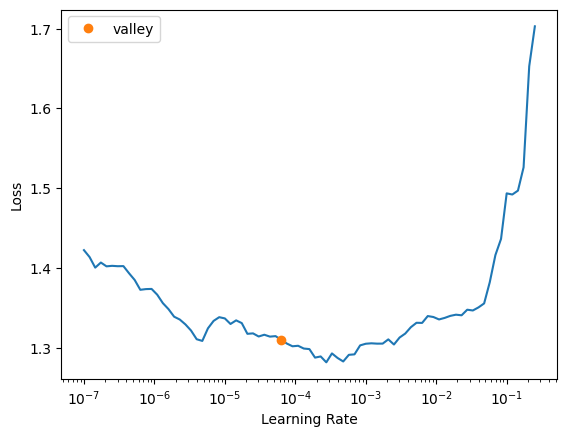

In [11]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(5,lr_max=slice(1e-7,2.1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.556559,0.800969,0.632231,11:46
1,0.380174,0.427261,0.803719,11:32
2,0.264614,0.173046,0.950413,11:26
3,0.204788,0.142528,0.946281,11:26
4,0.179569,0.101935,0.970041,11:25


In [15]:
learn.unfreeze()

In [16]:
learn.fit_one_cycle(2,lr_max=slice(1e-7,2.1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.268878,0.268834,0.884298,11:42
1,0.182078,0.099074,0.967975,11:37


In [17]:
learn.fit_one_cycle(3,lr_max=slice(1e-7,2.1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.265247,0.287366,0.891529,11:35
1,0.191732,0.077284,0.974174,11:25
2,0.146901,0.087151,0.974174,11:26


SuggestedLRs(valley=3.311311274956097e-06)

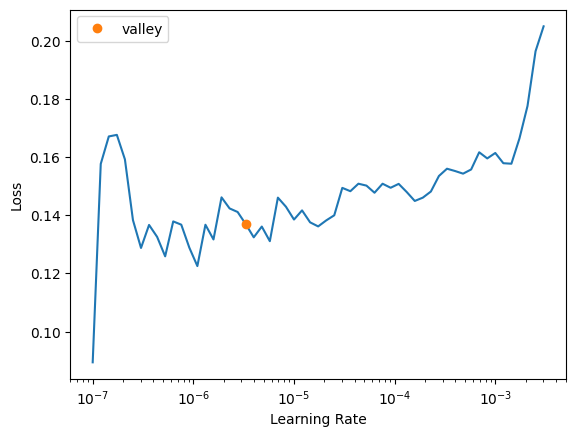

In [21]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(5,lr_max=slice(1e-6,2.1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.142168,0.059143,0.982438,11:42
1,0.149383,0.085782,0.974174,11:41
2,0.138628,0.065716,0.978306,11:26
3,0.144002,0.082212,0.973140,11:42
4,0.114272,0.065664,0.980372,11:26


In [26]:
learn.save('/kaggle/working/swin4')

Path('/kaggle/working/swin4.pth')

SuggestedLRs(valley=1.737800812406931e-05)

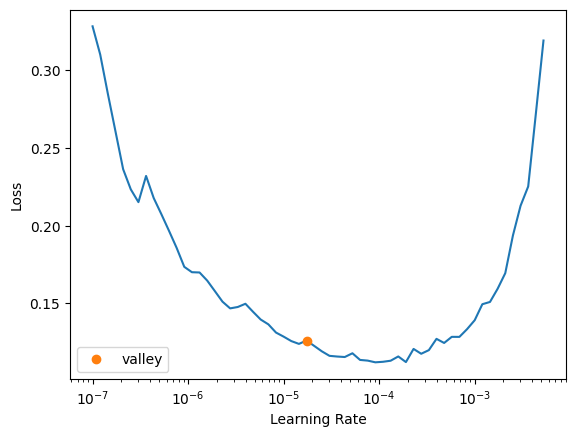

In [34]:
learn.lr_find()

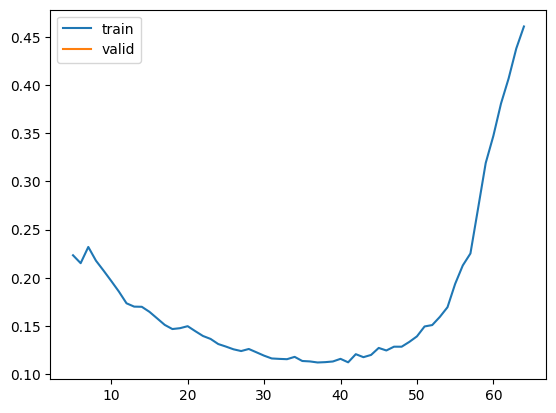

In [36]:
learn.recorder.plot_loss()

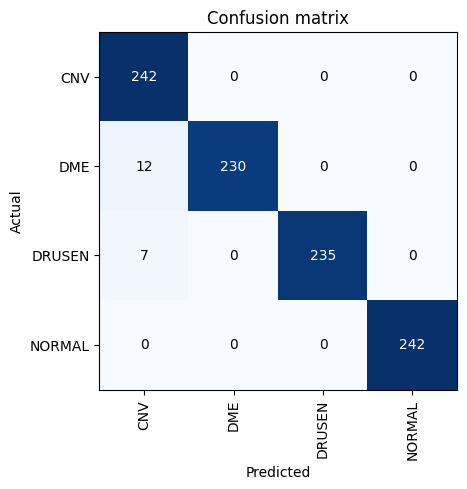

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()